In [1]:
import numpy as np
import pandas as pd
from docx import Document
import re

In [2]:
barley_df = pd.read_csv('barley_yield_from_1982.csv',sep=';').drop(columns=['Unnamed: 0'])
climate_df = pd.read_parquet('climate_data_from_1982.parquet')
doc = Document("202602 - ClientCo - Combined Meeting Minutes.docx")

## NLP for interviews_doc

In [3]:
text = "\n".join([p.text for p in doc.paragraphs])

# split the interviews
sections = text.split("Meeting minutes – Interview with")
sections = sections[1:] 

interviews = []

# we want to focus on discussions and development parts, sinec they can provide more insights
for sec in sections:
    lines = sec.strip().split("\n")
    
    name = lines[0].strip()
    
    discussion = ""
    vision = ""
    
    capture_discussion = False
    capture_vision = False
    
    for l in lines:
        if "Discussion and Perspectives" in l:
            capture_discussion = True
            capture_vision = False
        elif "Vision for Development" in l:
            capture_discussion = False
            capture_vision = True
        else:
            if capture_discussion:
                discussion += " " + l
            if capture_vision:
                vision += " " + l
    
    interviews.append({
        "stakeholder": name,
        "discussion": discussion.lower(),
        "vision": vision.lower()
    })

df_text = pd.DataFrame(interviews)


In [76]:
# bottom-up theme extraction → use case generation → prioritization

In [4]:
df_text["full_text"] = df_text["discussion"] + " " + df_text["vision"]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),     # word + 2-word phrases
    min_df=2               # at least show up in 2 interviews
)

X = vectorizer.fit_transform(df_text["full_text"])

terms = vectorizer.get_feature_names_out()
freq = X.sum(axis=0).A1

# get the seeds for use cases
df_terms = pd.DataFrame({
    "term": terms,
    "frequency": freq
}).sort_values("frequency", ascending=False)

In [79]:
df_terms.to_csv('interviews_terms.csv')

In [6]:
# since the use cases should not be too general, 
# we'd like to create a consulting judgment grouping for this problem

# 1st, a stopwords list should be created with help from LLM
stop_terms = [
    # --- ESG & generic business ---
    "esg", "sustainability", "sustainable", "environmental",
    "environmental impact", "esg impact", "esg initiatives",
    "clientco", "company", "company esg", "business",

    # --- generic consulting filler ---
    "impact", "strategy", "goals", "development",
    "potential", "opportunity", "future", "current", "new",
    "key", "crucial", "improve", "improving", "improvement",
    "project", "projects", "initiative", "initiatives", "teams", "department",

    # --- verbs / narrative ---
    "expressed", "explained", "believes", "convinced",
    "emphasized", "acknowledged", "interested",
    "sees", "started", "envisions",

    # --- generic adjectives ---
    "particularly", "especially", "friendly", "innovative",
    "better", "close", "long", "long term",

    # --- general process words ---
    "develop", "developing", "integration", "integrating",
    "integrate", "approach", "achieving", "set", "use",

    # --- generic risk/finance filler ---
    "risk", "economic", "profitability", "resources",

    # --- generic time / structure ---
    "time", "area", "topic", "term",

    # --- low information verbs ---
    "considering", "given", "offering", "needs", "decisions"
]

df_terms_clean = df_terms[
    (~df_terms["term"].isin(stop_terms)) &
    (df_terms["frequency"] >= 3)
]


In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

terms = df_terms_clean["term"].tolist()

embeddings = model.encode(terms)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 548.13it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [9]:
from sklearn.cluster import KMeans

k = 8 
kmeans = KMeans(n_clusters=k, random_state=0)

df_terms_clean["cluster"] = kmeans.fit_predict(embeddings)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7812\3751151777.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_terms_clean["cluster"] = kmeans.fit_predict(embeddings)


In [10]:
clusters = df_terms_clean.groupby("cluster")["term"].apply(list)

for c in clusters:
    print(c)
    print("-----")

['product development', 'improve company']
-----
['model', 'ai', 'machines', 'models']
-----
['farmers', 'ceo', 'factory']
-----
['data', 'data analytics', 'analytics', 'finance']
-----
['emissions', 'climate']
-----
['product', 'supply', 'consumer', 'change', 'products']
-----
['feasibility', 'challenges']
-----
['yield']
-----


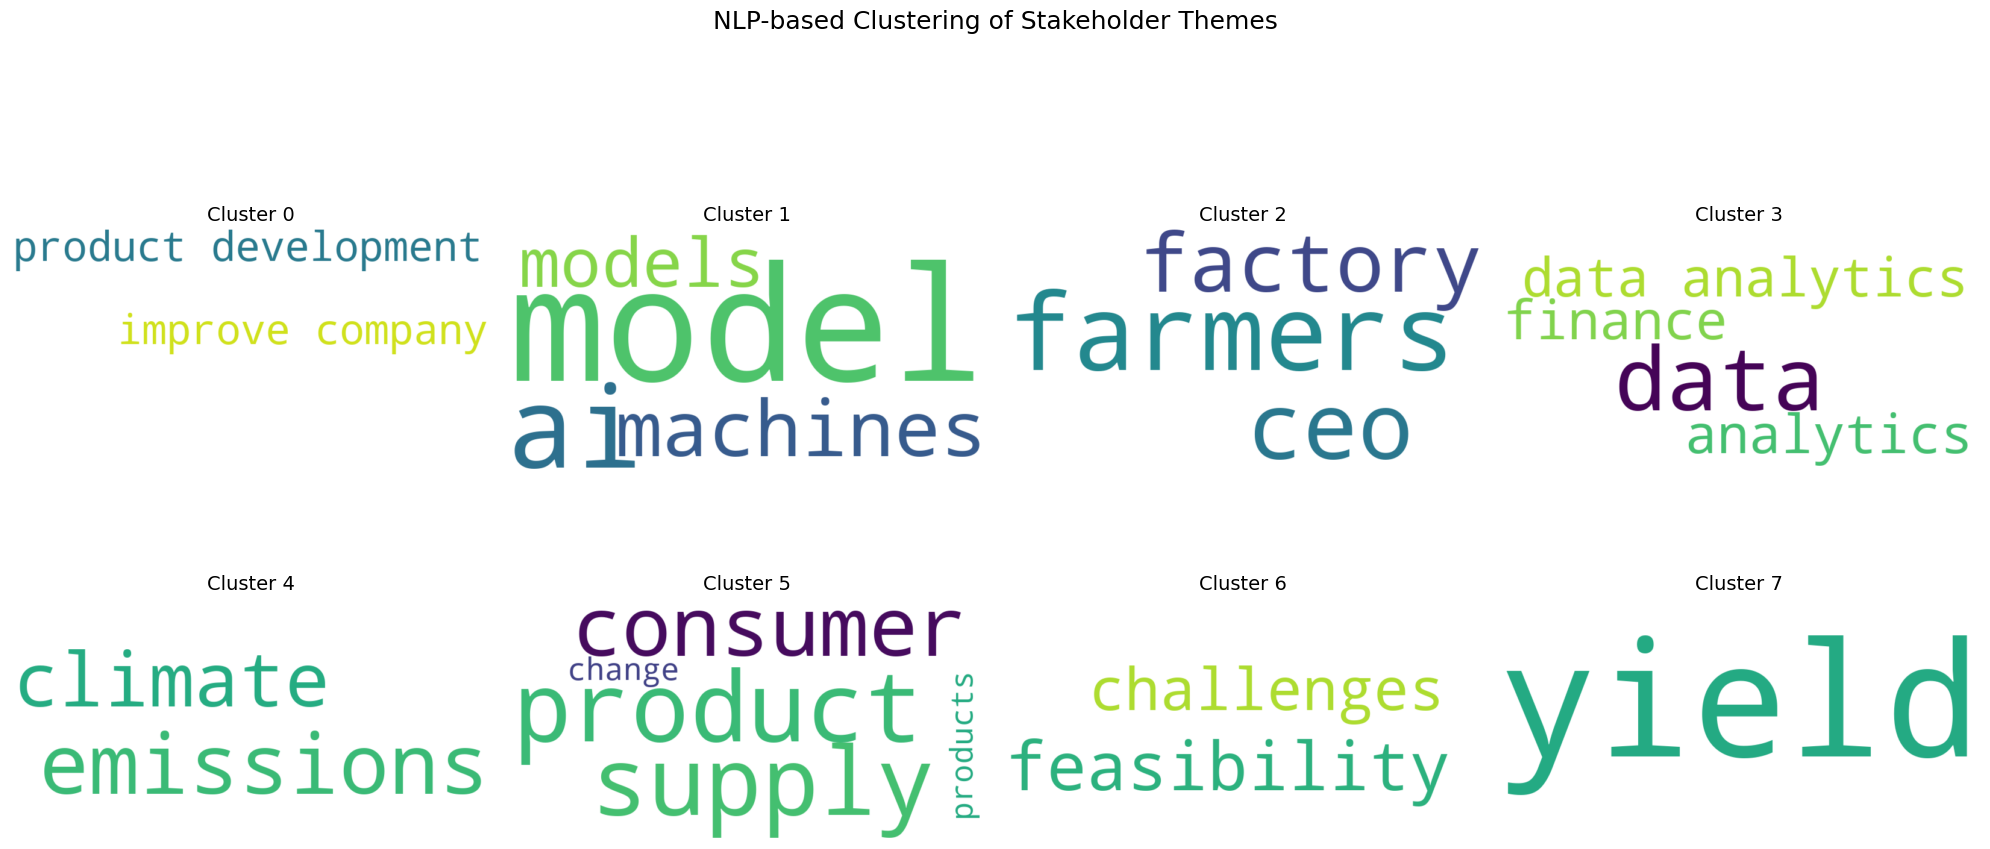

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

clusters = df_terms_clean.groupby("cluster")

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) 
axes = axes.flatten()

for i, (c, group) in enumerate(clusters):
    
    freq_dict = dict(zip(group["term"], group["frequency"]))
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",  
        max_words=30,
        contour_width=0
    ).generate_from_frequencies(freq_dict)
    
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {c}", fontsize=14)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("NLP-based Clustering of Stakeholder Themes", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("cluster_wordclouds.png", dpi=300)
plt.show()

## EDA for barley datasets

### Align the number of departments in 2 datasets

In [19]:
barley_df["department"] = barley_df["department"].str.strip().str.lower()
climate_df["nom_dep"] = climate_df["nom_dep"].str.strip().str.lower()

In [20]:
barley_deps = set(barley_df["department"].unique())
climate_deps = set(climate_df["nom_dep"].unique())
print(f"Number of departments in target:",
      len(barley_deps))

print(f"Number of deparments in climate dataset: {len(climate_deps)}")

Number of departments in target: 97
Number of deparments in climate dataset: 89


In [21]:
only_in_barley = barley_deps - climate_deps
only_in_climate = climate_deps - barley_deps

print("Only in barley:", only_in_barley)
print("Only in climate:", only_in_climate)

# Some departments are not consistently covered across datasets, 
# requiring alignment before modeling

Only in barley: {'corse_du_sud', 'seine_seineoise', 'val_de_marne', 'hauts_de_seine', 'haute_corse', 'val_d_oise', 'seine_saint_denis', 'paris'}
Only in climate: set()


In [22]:
problem_deps = [
    'corse_du_sud', 'seine_seineoise', 'val_de_marne',
    'hauts_de_seine', 'haute_corse', 'val_d_oise',
    'seine_saint_denis', 'paris'
]

subset = barley_df[barley_df["department"].isin(problem_deps)]
subset

,department,year,yield,area,production
703,corse_du_sud,1982,1.20,100.0,120.0
704,corse_du_sud,1983,1.60,60.0,96.0
705,corse_du_sud,1984,1.50,50.0,75.0
706,corse_du_sud,1985,1.50,40.0,60.0
707,corse_du_sud,1986,1.80,50.0,90.0
...,...,...,...,...,...
3319,val_de_marne,2014,7.50,105.0,787.5
3320,val_de_marne,2015,7.30,60.0,440.5
3321,val_de_marne,2016,NaN,110.0,561.0
3322,val_de_marne,2017,7.10,120.0,852.0


In [25]:
barley_df.describe()

,year,yield,area,production
count,3583.000000,3336.000000,3468.000000,3461.000000
mean,1999.971532,5.212239,18767.079585,110239.297180
std,10.664744,1.369354,20266.789390,133060.332166
min,1982.000000,0.813560,0.000000,0.000000
25%,1991.000000,4.242530,3766.500000,17240.000000
50%,2000.000000,5.261230,11810.500000,56744.900000
75%,2009.000000,6.225615,27495.500000,153285.200000
max,2018.000000,8.400000,119310.000000,919249.600000


In [ ]:
subset.groupby("department").agg({
    "yield": ["count", "mean"],
    "area": "mean",
    "production": "mean"
})

# based on the overall description of barley_df, 
# most departments with problem are not important to be considered

yield                   area    production
                  count      mean         mean          mean
department                                                  
corse_du_sud         30  2.066667    40.600000     74.266667
haute_corse          36  2.950000   484.891892   1452.005405
hauts_de_seine        0       NaN     0.000000      0.000000
paris                 0       NaN          NaN           NaN
seine_saint_denis    30  6.245381    19.303030    125.737500
seine_seineoise       0       NaN          NaN           NaN
val_d_oise           37  6.897887  3563.000000  24701.174324
val_de_marne         35  6.562375    99.324324    633.270270

In [28]:
barley_df = barley_df[~barley_df["department"].isin(problem_deps)]

In [29]:
barley_df.describe()

,year,yield,area,production
count,3293.0000,3168.000000,3289.000000,3286.000000
mean,2000.0000,5.223347,19741.237458,115806.712505
std,10.6787,1.316092,20361.733156,134273.631391
min,1982.0000,0.813560,10.000000,30.000000
25%,1991.0000,4.283862,5000.000000,22361.700000
50%,2000.0000,5.243750,12800.000000,63399.000000
75%,2009.0000,6.189648,28700.000000,161112.500000
max,2018.0000,8.400000,119310.000000,919249.600000


### Cleaning for barley_df

In [31]:
barley_df.duplicated(subset=["department","year"]).sum()

np.int64(0)

In [32]:
barley_df.isna().mean()

department    0.000000
year          0.000000
yield         0.037959
area          0.001215
production    0.002126
dtype: float64

In [37]:
# 1st situation: only yield is missing, then it can be calculated
mask = barley_df["yield"].isna() & barley_df["area"].notna() & barley_df["production"].notna()
barley_df.loc[mask, "yield"] = barley_df["production"] / barley_df["area"]

In [41]:
# 2nd situation: only production is missing
mask = barley_df["production"].isna() & barley_df["area"].notna() & barley_df["yield"].notna()
barley_df.loc[mask, "production"] = barley_df["yield"] * barley_df["area"]

In [45]:
barley_df[barley_df['production'].isna()]

,department,year,yield,area,production
439,bas_rhin,2014,NaN,NaN,NaN
440,bas_rhin,2015,NaN,NaN,NaN
1290,haut_rhin,2014,NaN,NaN,NaN
1291,haut_rhin,2015,NaN,NaN,NaN


In [52]:
barley_df[
    (barley_df['department'].isin(['haut_rhin', 'bas_rhin'])) &
    (barley_df['year'] > 2011) &
    (barley_df['year'] < 2018)
]

,department,year,yield,area,production
437,bas_rhin,2012,5.92400,3750.0,22215.0
438,bas_rhin,2013,5.80000,3000.0,17400.0
439,bas_rhin,2014,NaN,NaN,NaN
440,bas_rhin,2015,NaN,NaN,NaN
441,bas_rhin,2016,5.11000,3560.0,18191.6
442,bas_rhin,2017,7.07000,3550.0,25098.5
1288,haut_rhin,2012,6.50000,1365.0,8872.5
1289,haut_rhin,2013,5.84848,1320.0,7720.0
1290,haut_rhin,2014,NaN,NaN,NaN
1291,haut_rhin,2015,NaN,NaN,NaN


In [ ]:
# maybe we can just drop them, only 4 rows
# or interpolate based their ranking in all departments?

### Cleaning for Climate_df

In [54]:
# pivot to get the feature columns
climate_wide = climate_df.pivot_table(
    index=['scenario', 'nom_dep', 'code_dep', 'time', 'year'],
    columns='metric',
    values='value',
    aggfunc='mean'    # if there're duplicates
).reset_index()  

climate_wide

metric,scenario,nom_dep,code_dep,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
0,historical,ain,01,1982-01-01 12:00:00,1982,279.337311,276.292267,3.298677e-05
1,historical,ain,01,1982-01-02 12:00:00,1982,277.687225,275.092407,1.394672e-04
2,historical,ain,01,1982-01-03 12:00:00,1982,278.388794,276.418518,9.061195e-05
3,historical,ain,01,1982-01-04 12:00:00,1982,283.519043,278.893372,5.659108e-05
4,historical,ain,01,1982-01-05 12:00:00,1982,281.122253,278.887207,2.570244e-04
...,...,...,...,...,...,...,...,...
4583495,ssp5_8_5,yvelines,78,2050-12-27 12:00:00,2050,275.954895,272.477722,3.356686e-05
4583496,ssp5_8_5,yvelines,78,2050-12-28 12:00:00,2050,281.925537,279.003143,3.531645e-06
4583497,ssp5_8_5,yvelines,78,2050-12-29 12:00:00,2050,285.255005,283.358429,4.072561e-06
4583498,ssp5_8_5,yvelines,78,2050-12-30 12:00:00,2050,284.745300,280.749329,4.087608e-09


In [56]:
dup = climate_wide.duplicated(subset=['scenario','nom_dep','time'])
print("Duplicate rows:", dup.sum())

Duplicate rows: 0


In [57]:
# change to degrees celsius
climate_wide["near_surface_air_temperature"] = climate_wide["near_surface_air_temperature"] - 273.15
climate_wide["daily_maximum_near_surface_air_temperature"] = climate_wide["daily_maximum_near_surface_air_temperature"] - 273.15

In [59]:
climate_wide.isna().mean()

metric
scenario                                      0.00000
nom_dep                                       0.00000
code_dep                                      0.00000
time                                          0.00000
year                                          0.00000
daily_maximum_near_surface_air_temperature    0.02295
near_surface_air_temperature                  0.00000
precipitation                                 0.02295
dtype: float64

In [60]:
climate_wide = climate_wide.sort_values(["nom_dep","time"])

climate_wide["daily_maximum_near_surface_air_temperature"] = climate_wide.groupby("nom_dep")["daily_maximum_near_surface_air_temperature"].transform(lambda x: x.interpolate())
climate_wide["precipitation"] = climate_wide.groupby("nom_dep")["precipitation"].transform(lambda x: x.interpolate())

### Feature Engineering

In [ ]:
# 1st: Growing Season Mean 
#      (Spring Barley: March-July; Winter barley:Oct (prev year) → June (current year))
# 2nd: Is natural disaster or exterme climate exists in growing season
#      1. Heat Stress: the num of days with tem>30 in growing season
#      2. Drought: rain_sum in growing_season/once the sum of one week under~
#                  no rainy days in a row (precipitation < 1mm)
#      3. Flood / heavy rain: > 20mm/day